In this document we develop the necessary functions to apply the *Unbiased EnKBF*. Some of the functions are already computed and are taken from https://github.com/fangyuan-ksgk/Multilevel-Ensemble-Kalman-Bucy-Filter

The system that we are concerned with is:
\begin{align}
dX_t =& A X_t dt + R_1 dW_t,\\
dY_t =& H X_t dt + R_2 dV_t
\end{align}


Model settings: (Conditions that the model needs to satsify)
1. Signal of dimension 'dim', and the observtations are in dimension 'dim_o'
2. $x_0|y_0 \sim N(m_0,C_0)$
3. $R_1, R_2$ is symmetric
4. $R_1$ is commutable with $A$
5. $(A+A')$ is invertible
6. For convenience purpose the target function is $\varphi(x)=x^{1}$, where $x=(x^{1},x^{2},...,x^{dim})$

In this code, I will include the $A,R_1,R_2,H,m_0,C_0$ as parameter as well, so that it's easily scalable wrt any dimension dim.
Note that dim needs to be bigger than 1, as the matrix multiplication sign '@' in python doesn't support '*' in one dimension.

First the input value for $A,R1,R2,H,m_0,C_0$ need to be folded into one variable.
One need to specify the model in the cell below first.

If we where going to compare with the paper, there would be a difference in the notations of the equations: In the paper we use $C$ instead of $H$(observation matrix?), $R_1$ instead of $R_1^{\frac{1}{2}}$, and $R_2$ instead of $R_2^{\frac{1}{2}}$.

In [14]:
import numpy as np
import progressbar
from scipy import linalg as la
from scipy.sparse import identity
from scipy.sparse import rand
from scipy.sparse import diags
from scipy.sparse import triu
amm=2.
bmm=2.
cmm=50.
## dim is dimension value
dim=10
dim_o=10
A1 = -rand(dim,dim,density=0.75).toarray()/5  #rand is a function that generates a random sparce matrix with entries
# between 0 and 1.
A2 = triu(A1, k=1).toarray()/(10) #Upper triangular matrix 
A = diags(np.random.normal(-0.5,0,dim),0).toarray()/50 + A2 - A2.T 
## we denote R1^{1/2},R2^{1/2} as R1,R2 repectively for convenience
## Non-Identity covariance matrix
R1=(identity(dim).toarray() + np.tri(dim,dim,1) - np.tri(dim,dim,-2))/5#2
R2=(identity(dim_o).toarray() + np.tri(dim_o,dim_o,1) - np.tri(dim_o,dim_o,-2))/5#2

H=rand(dim_o,dim,density=0.75).toarray()/20
m0=np.zeros(dim)+6
C0=identity(dim).toarray()
## Collection of input 
collection_input = [dim,dim_o,A,R1,R2,H,m0,C0]
#print(A,R1,H,R2,m0,C0)


Generation of the realization of the process 

In [2]:
"""M:We can simulate the UO process exactly as shown in 
Markov Processes 1st Edition An Introduction for Physical Scientists Eq. E-12.b
"""
def gen_data(T,l,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    tau=1./2**(l)
    L=la.expm(A*tau)
    ## We are going to need W to be symmetric! 
    W=(R1@R1)@(la.inv(A+A.T)@(L@(L.T)-I))
    C=tau*H
    V=(R2@R2)*tau

    v=np.zeros((J+1,dim,1))
    z=np.zeros((J+1,dim_o,1))
    v[0]=np.random.multivariate_normal(m0,C0,(1)).T
    z[0]=np.zeros((dim_o,1))


    for j in range(J):
        ## truth
        #M: how do we know this is the truth? 
        v[j+1] = L@v[j] + np.random.multivariate_normal(np.zeros(dim),W,(1)).T
        ## observation
        z[j+1] = z[j] + C@v[j+1] + np.random.multivariate_normal(np.zeros(dim_o),V,(1)).T
        
    return([z,v])

def gen_model(dim):
    ## dim is dimension value
    dim_o=dim
    A1 = -rand(dim,dim,density=0.75).toarray()/1
    A2 = triu(A1, k=1).toarray()/(cmm)
    A = diags(np.random.normal(-0.5,0,dim),0).toarray()/50 + A2 - A2.T
    ## we denote R1^{1/2},R2^{1/2} as R1,R2 repectively for convenience
    ## Non-Identity covariance matrix
    R1=(identity(dim).toarray() + np.tri(dim,dim,1) - np.tri(dim,dim,-2))/amm
    R2=(identity(dim_o).toarray() + np.tri(dim_o,dim_o,1) - np.tri(dim_o,dim_o,-2))/bmm

    H=rand(dim_o,dim,density=0.75).toarray()/20
    m0=np.zeros(dim)+6
    C0=identity(dim).toarray()
    ## Collection of input 
    collection_input = [dim,dim_o,A,R1,R2,H,m0,C0]
    return collection_input



In [3]:
def KBF(T,l,lmax,z,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    tau=2**(-l)
    L=la.expm(A*tau)
    W=(R1@R1)@(la.inv(A+A.T)@(L@(L.T)-I))
    ## C: dim_o*dim matrix
    C=tau*H
    V=(R2@R2)*tau
    
    z=cut(T,lmax,l,z)
    m=np.zeros((J+1,dim,1))
    c=np.zeros((J+1,dim,dim))
    m[0]=6*np.ones((dim,1))
    c[0]=C0
    
    for j in range(J):
        ## prediction mean-dim*1 vector
        mhat=L@m[j]
        ## prediction covariance-dim*dim matrix
        chat=L@c[j]@(L.T)+W
        ## innovation-dim_o*1 vector
        d=(z[j+1]-z[j])-C@mhat
        ## Kalman gain-dim*dim_o vector
        K=(chat@(C.T))@la.inv(C@chat@(C.T)+V)
        ## update mean-dim*1 vector
        m[j+1]=mhat+K@d
        ## update covariance-dim*dim matrix
        c[j+1]=(I-K@C)@chat
        
    return([m,c])

In [4]:
# Copies the i*2^(lmax-l) positions for i=0,1,...,T*2^l
def cut(T,lmax,l,v):
    ind = np.arange(T*2**l+1)
    rtau = 2**(lmax-l)
    w = v[ind*rtau]
    return(w)

Testing Floor: KBF

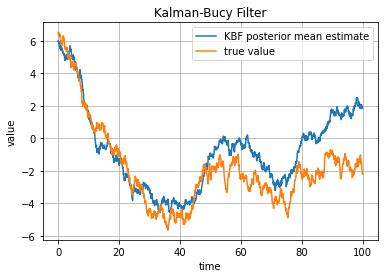

In [5]:
## test:good
import numpy as np
import matplotlib.pyplot as plt 
from scipy import linalg as la
from scipy.sparse import identity
T=100
lmax=5
l=4
tau=2**(-l)
## The with numpy.errstate argument is used to avoid any stupid warning
with np.errstate(divide='ignore'):
    [z,v] = gen_data(T,lmax,collection_input)
    [m,c] = KBF(T,l,lmax,z,collection_input)
v=cut(T,lmax,l,v)
J=T*(2**l)
x1 = tau*np.arange(J+1)
plt.plot(x1,m[:,4],label="KBF posterior mean estimate")
plt.plot(x1,v[:,4],label="true value")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()
plt.show()

Ensemble Kalman Bucy Filter Function ： Euler

In [15]:
def DEnKBF(T,l,lz,lmax,z,N,collection_input,w,v):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    dt=2**(-l)  
    m=np.zeros((J+1,dim,1))
    c=np.zeros((J+1,dim,dim))
    z_copy=cut(T,lz,l,z)
    w_copy=cut(T,lmax,l,w)
    dw_copy=w_copy[1:]-w_copy[:-1]
    v_copy=cut(T,lmax,l,v)
    dv_copy=v_copy[1:]-v_copy[:-1]
    #both of these lines use concatenate because the brownian increments are T*2^lmax instead of T*2^lmax+1
    #and the cut() function uses arrays of dim T*2^lmax+1.
   
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    inv=la.inv(R2)@la.inv(R2)
    for j in range(J):
        #dw = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
        #dv = np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,N).T
        ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
        ## x-m[j]:dim*N c[j]:dim*dim
        
        step1=(((x-m[j]).T)@(H.T))
        step2=step1@(inv)
        step3=step2@( (z_copy[j+1]-z_copy[j]) - (H@(x+m[j])*dt/2.))
        step4=(x-m[j])@step3 /(N-1)
        
        x = x + A@x*dt + R1@(dw_copy[j].T) + step4
        m[j+1] = (np.mean(x, axis=1)).reshape(dim,1)
        c[j+1]=((x-m[j+1])@((x-m[j+1]).T))
    
    return([m,c,x])









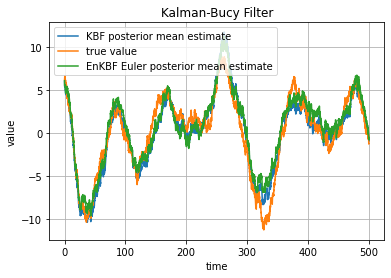

In [7]:
## test:Good 
import numpy as np
import matplotlib.pyplot as plt 
from scipy import linalg as la
from scipy.sparse import identity


T=500
lz=4
lmax=4
l=4
tau=2**(-l)
N=100
dt=2**(-lmax)

I=identity(dim).toarray()
I_o=identity(dim_o).toarray()
dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(lmax),N))
dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(lmax),N))

w1=np.cumsum(dw1,axis=0) 
w2=np.cumsum(dw2,axis=0) 
w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)

## The with numpy.errstate argument is used to avoid any stupid warning
with np.errstate(divide='ignore'):
    [z,v] = gen_data(T,lz,collection_input)
    [m,c] = KBF(T,l,lz,z,collection_input)
    [m1,c1,y1] = DEnKBF(T,l,lz,lmax,z,N,collection_input,w1,w2)
    #[m2,c2] = DEnKBF(T,l,lmax,z,N,collection_input)
v1=cut(T,lmax,l,v)
z1=cut(T,lmax,l,z)


J=T*(2**l)
x1 = tau*np.arange(J+1)
#print(m1[:,2].T[0])

plt.plot(x1,m[:,1],label="KBF posterior mean estimate")
plt.plot(x1,v1[:,1],label="true value")
plt.plot(x1,m1[:,1],label="EnKBF Euler posterior mean estimate")
#plt.plot(x1,z1[:,1],label="Observations ")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()
plt.show()

Testing of the "new" EnKBF function

Sequence of samples

In [16]:
#gives a sequence of numbers [N0,N1,...,Np]
def nseq(p,N0):
    #N0, The base number of particles has to be considerably big(N0>2) to avoid overflow.
    seq=np.concatenate(([0],N0*np.array([2**i for i in range(p+1)])))
    seq_diff=seq[1:]-seq[:-1]
    return [seq,seq_diff]
nseq(4,19)

[array([  0,  19,  38,  76, 152, 304]), array([ 19,  19,  38,  76, 152])]

The following function computes the (3.2) in the paper, $\Xi_{l,p}\mathbb{P}_P(p)$.

Modified version:
Arguments of this function 

p:  level of number of samples 

N0:  base number of samples 

l:  level of time discretization, $l$ $\in$ ${0,1,...,lmax=lz-l0}$ 

l0: shift of the levels, i.e. the actual time step for a value of l is $2^{-l0-l}$

lz:  level of discretization of the observations 

phi: function applied to the EnKBF "particles"

T: time span of the filter

z: observations

In [17]:
def Dplevels(p,N0,l,l0,lz,phi,T,z,collection_input):
    [dim,dim_o]=collection_input[0:2]
    [seq,seq_diff]=nseq(p,N0)
    l_original=l
    l+=l0
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    dt=2**(-l)
    N=seq[-1]
    
    funct_val=np.zeros((dim,p+1))
    funct_val2=np.zeros((dim,p+1))
    if l_original==0:
        if p>0:
            
            for i in range(p+1):
                dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[i]))
                dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[i]))
                w1=np.cumsum(dw1,axis=0) 
                w2=np.cumsum(dw2,axis=0) 
                w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
                w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
                [m,c,x]=EnKBF(T,l,lz,l,z,seq_diff[i],collection_input,w1,w2)
                funct_val[:,i]=np.sum(phi(x),axis=1)
            xi= ((1./seq[-1]-1./seq[-2])*np.sum(funct_val[:,:-1],axis=1)+funct_val[:,-1]/seq[-1]).reshape((dim,1))
        else:
            dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[p]))
            dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[p]))
            w1=np.cumsum(dw1,axis=0) 
            w2=np.cumsum(dw2,axis=0) 
            w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
            w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
            [m,c,x]=EnKBF(T,l,lz,l,z,seq_diff[0],collection_input,w1[:,seq[p]:seq[p+1],:],w2[:,seq[p]:seq[p+1],:])
            funct_val[:,0]=np.sum(phi(x),axis=1)
            xi= (1./seq[-1])*funct_val    
    if l_original>0:
        if p==0:
            dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[p]))
            dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[p]))
            w1=np.cumsum(dw1,axis=0) 
            w2=np.cumsum(dw2,axis=0) 
            w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
            w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
            [m,c,x]=EnKBF(T,l,lz,l,z,seq_diff[0],collection_input,w1[:,seq[p]:seq[p+1],:],w2[:,seq[p]:seq[p+1],:])
            funct_val[:,0]=np.sum(phi(x),axis=1).T
            xi1= (1./seq[-1])*funct_val
            [m,c,x]=EnKBF(T,l-1,lz,l,z,seq_diff[0],collection_input,w1[:,seq[p]:seq[p+1],:],w2[:,seq[p]:seq[p+1],:])
            funct_val2[:,0]=np.sum(phi(x),axis=1).T
            xi2= (1./seq[-1])*funct_val2
            xi=xi1-xi2
        
        if p>0:
            
            for i in range(p+1):
                dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[i]))
                dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[i]))
                w1=np.cumsum(dw1,axis=0) 
                w2=np.cumsum(dw2,axis=0) 
                w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
                w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
                [m,c,x]=EnKBF(T,l,lz,l,z,seq_diff[i],collection_input,w1,w2)
                funct_val[:,i]=np.sum(phi(x),axis=1)
                [m,c,x]=EnKBF(T,l-1,lz,l,z,seq_diff[i],collection_input,w1,w2)
                funct_val2[:,i]=np.sum(phi(x),axis=1)              
                
            xi1= ((1./seq[-1])-(1./seq[-2]))*np.sum(funct_val[:,:-1],axis=1)+funct_val[:,-1]/seq[-1]
            xi2= (1./seq[-1]-1./seq[-2])*np.sum(funct_val2[:,:-1],axis=1)+funct_val2[:,-1]/seq[-1]
            xi=(xi1-xi2).reshape((dim,1))
    return xi

def phi2(x):
    return x

Sampling function:

This functions takes as argument an array representing the cumulative distribution of a random variable,and samples from it. 

cumulative[0]=F(1)<cumulative[1]=F(2)<...<cumulative[n-1]=cumulative[-1]=F(n)=1.

In [18]:
def sampling(cumulative):
    u=np.random.uniform()
    for i in range(len(cumulative)):
        if cumulative[i]>u:
            p=i
            break
            
    return p

Cumulatives

Creates a pdf(and its cdf) $P(x)$ $x\in \{0,1,2,...,lmax\}$

In [19]:
def DF_l(lmax):
    array=np.arange(lmax+1)
    pdf=2**(-1.5*array)
    pdf=pdf/np.sum(pdf)
    cdf= np.cumsum(pdf)
    return pdf, cdf



def DF_p(lmax,l):
    if (lmax-l)<=4:
        array=np.arange(lmax-l+1)
        pdf=2**(4-array)
        pdf=pdf/np.sum(pdf)
        cdf= np.cumsum(pdf)
    if lmax-l>=5:
        array1=np.arange(5)
        array2=np.arange(5,lmax-l+1)
        pdf1=2**(4-array1)
        pdf2=array2*(np.log2(array2))**2/(2**(array2))
        pdf=np.concatenate((pdf1,pdf2))
        pdf=pdf/np.sum(pdf)
        cdf= np.cumsum(pdf)
    return [pdf,cdf]

Single term estimator 
B: Number of i.i.d. samples of the unbiased estimator

In [20]:
def single_term(B,N0,l0,lz,phi2,T,z,collection_input):
    lmax=lz-l0
    [dim,dim_o]=collection_input[0:2]
    #lz=l0+lmax    
    estimators=np.zeros((B,dim))
    pls=np.zeros((B,2))
    estimators_sum=0
    [pdf_l,cdf_l]=DF_l(lmax)
    for i in range(B):
        l=sampling(cdf_l)
        [pdf_p,cdf_p]=DF_p(lmax,l)
        #print(lmax,l,pdf_p)
        p=sampling(cdf_p)
        #print(i,l,p)
        xi=plevels(p,N0,l,l0,lz,phi2,T,z,collection_input)/(pdf_p[p]*pdf_l[l])
        #print(((xi.T)[0]))
        estimators[i]=(xi.T)[0]
        pls[i]=[p,l]
    
    estimators_mean=np.mean(estimators,axis=0)
    return [estimators_mean,pls]

Primary **test** for the single term estimator 

In [21]:
dim=5
T=5
N0=50
lz=12
l0=5
collection_input=gen_model(dim)
[z,v]=gen_data(T,lz,collection_input)

In [22]:
#B=10
#single_term(B,N0,l0,lz,phi2,T,z,collection_input)

In [23]:
lmax=lz
l=lz
tau=2**(-l)
dt=2**(-lmax)
N=50

dim_o=collection_input[1]
I=identity(dim).toarray()
I_o=identity(dim_o).toarray()
dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(lmax),N))
dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(lmax),N))
w1=np.cumsum(dw1,axis=0) 
w2=np.cumsum(dw2,axis=0) 
w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)

#EnKBF(T,l,lz,lmax,z,N,collection_input,w1,w2)[0][-1]

Linear regression function:

In [24]:
def coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return np.asarray((b_0, b_1)) 

Control of the bias:

Let the bias of the EnKBF be 

$$
\begin{align}
\operatorname{E}\left(\eta^{N,l}_t-\eta_t\right)=&\operatorname{E}\left(\eta^{N,l}_t-\eta^l_t\right)+\operatorname{E}\left(\eta^{l}_t-\eta_t\right),\\
&=k_1 \Delta_l+k_2\left(\frac{1}{N}\right),
\end{align}
$$

We obtain a bias
$$
\begin{align}
\operatorname{E}\left(\eta^{N,l}_t-\eta^{l}_t\right)
=k_2 \frac{1}{N},
\end{align}
$$
Now, using Richardson extrapolation

$$
\begin{align}
\operatorname{E}\left(\eta^{N_p,l}_t-\eta^{N_{p-1},l}_t\right)
=-k_2 \frac{1}{N_p},
\end{align}
$$
if $N_p=2^p$, which can be the case.  Taking the log of the absolute value
$$
\begin{align}
\operatorname{Ln}|\operatorname{E}\left(\eta^{N_p,l}_t-\eta^{N_{p-1},l}_t\right)|
=\operatorname{Ln}|k_2 \Delta_l|=\operatorname{Ln}|k_2|-p\operatorname{Ln}(2)=\operatorname{Ln}|k_2|+p\operatorname{Ln}(1/2).
\end{align}
$$

### New version

In [17]:
def fit_k2(seed_val,pmax,T,N0,l,collection_input,z,lz,REP):
    np.random.seed(seed_val)
    [dim,dim_o]=collection_input[0:2]
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    abscisas=np.array(range(0,pmax))+1
    dim=collection_input[0]
    ordenadas=np.zeros((pmax,dim))
    rep_array=np.zeros((REP,dim))
    lmaxE=l
    for i in range(pmax):
        p=i+1
        dt=2**(-lmaxE)
        with progressbar.ProgressBar(max_value=REP) as bar:
            print("Current level is",p,". ",pmax-p,"remaining.")
            for rep in range(REP):
                dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(lmaxE),N0*2**(p)))
                dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(lmaxE),N0*2**(p)))
                w1=np.cumsum(dw1,axis=0) 
                w2=np.cumsum(dw2,axis=0) 
                w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
                w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
                Enk1=EnKBF(T,l,lz,lmaxE,z,N0*2**(p),collection_input,w1,w2)[0][-1][:,0]
                Enk2=EnKBF(T,l,lz,lmaxE,z,N0*2**(p-1),collection_input,w1[:,:N0*2**(p-1),:],w2[:,:N0*2**(p-1),:])[0][-1][:,0]
                rep_array[rep]=(Enk1-Enk2)
                bar.update(rep)
        ordenadas[i]=np.mean(rep_array,axis=0)
    bs=np.zeros((dim,2))
    for i in range(dim):
        bs[i]=coef(abscisas,np.log2(np.abs(ordenadas)).T[i])
    ordenadas=np.log2(np.abs(ordenadas))
    bs=2**bs
    bs[:,0]=N0*bs[:,0]
    return [bs,abscisas,ordenadas]

In [18]:
dim=2
T=80
amm=10.
bmm=20.
cmm=10.
lz=11
seed_val_col=5
seed_val_obs=5
np.random.seed(seed_val_col)
collection_input=gen_model(dim)
np.random.seed(seed_val_obs)
[z,v]=gen_data(T,lz,collection_input)

pmax=6
N0=10
l=4
REP=2000

In [190]:
seed_val=5
[b,abscisas,ordenadas]=fit_k2(seed_val,pmax,T,N0,l,collection_input,z,lz,REP)

  0% (0 of 2000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level is 1 .  5 remaining.


100% (2000 of 2000) |####################| Elapsed Time: 0:05:24 Time:  0:05:24
  0% (0 of 2000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level is 2 .  4 remaining.


100% (2000 of 2000) |####################| Elapsed Time: 0:05:35 Time:  0:05:35
  0% (0 of 2000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level is 3 .  3 remaining.


100% (2000 of 2000) |####################| Elapsed Time: 0:06:04 Time:  0:06:04


Current level is 4 .  2 remaining.


100% (2000 of 2000) |####################| Elapsed Time: 0:07:21 Time:  0:07:21


Current level is 5 .  1 remaining.


100% (2000 of 2000) |####################| Elapsed Time: 0:11:39 Time:  0:11:39


Current level is 6 .  0 remaining.


100% (2000 of 2000) |####################| Elapsed Time: 0:20:57 Time:  0:20:57


In [191]:
[b,abscisas,ordenadas]

[array([[0.03133436, 0.65730479],
        [1.29854925, 0.46008071]]),
 array([1, 2, 3, 4, 5, 6]),
 array([[-10.42900231,  -4.17222161],
        [ -8.30931094,  -5.07336932],
        [-11.55658248,  -6.18988001],
        [ -8.25832634,  -7.13251629],
        [ -9.38972486,  -9.38759159],
        [-14.67796432,  -9.23544879]])]

Text(0, 0.5, '$\\operatorname{Log2}\\left(\\operatorname{E}\\left(\\eta^{l}_t-\\eta_t\\right)\\right)$')

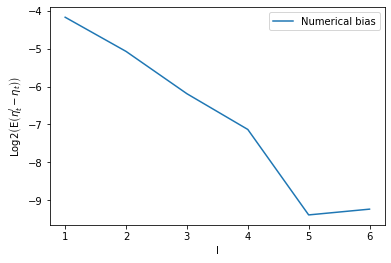

In [194]:
plt.plot(abscisas,ordenadas[:,1],label="Numerical bias")
#plt.plot(abscisas,np.log2(b[0])+np.log2(b[1])*abscisas,label="Linear regression")
#plt.plot(abscisas,ordenadas[0]-4*np.log2(1/2.)+np.log2(1/2.)*abscisas,label=r"Reference curve $a+l*Log(1/2)$")
plt.legend()
plt.xlabel("l")
plt.ylabel(r"$\operatorname{Log2}\left(\operatorname{E}\left(\eta^{l}_t-\eta_t\right)\right)$")

In [195]:
np.sqrt(np.sum(b[:,0]**2))

1.2989272445661426

In [28]:
def cost_function(T,pls,N0):
    cost=0
    pls=np.sum(pls,axis=1)
    for i in range(len(pls)):
        cost+=2**(pls[i])
    cost=cost*T*N0
    return cost

In this section we are going to compute the coupled sum estimators in the number of samples level.
The only two changes with respect the function plevels is that we have the additional arguments cdf_p and pdf_p, and that we are compututing $\Xi_{l,p}$ instead of $\Xi_{l,p}\mathbb{P}_P(p)$

In [20]:
def plevels_coupled(p,N0,l,l0,lz,phi,T,z,collection_input,cdf_p,pdf_p):
    [dim,dim_o]=collection_input[0:2]
    [seq,seq_diff]=nseq(p,N0)
    l_original=l
    l+=l0
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    dt=2**(-l)
    N=seq[-1]
    
    funct_val=np.zeros((dim,p+1))
    funct_val2=np.zeros((dim,p+1))
    if l_original==0:
        if p>0:
            
            for i in range(p+1):
                dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[i]))
                dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[i]))
                w1=np.cumsum(dw1,axis=0) 
                w2=np.cumsum(dw2,axis=0) 
                w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
                w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
                [m,c,x]=EnKBF(T,l,lz,l,z,seq_diff[i],collection_input,w1,w2)
                funct_val[:,i]=np.sum(phi(x),axis=1)
            xi= ((1./seq[-1]-1./seq[-2])*np.sum(funct_val[:,:-1],axis=1)+funct_val[:,-1]/seq[-1]).reshape((dim,1))
            xi=xi/pdf_p[p]
        else:
            dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[p]))
            dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[p]))
            w1=np.cumsum(dw1,axis=0) 
            w2=np.cumsum(dw2,axis=0) 
            w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
            w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
            [m,c,x]=EnKBF(T,l,lz,l,z,seq_diff[0],collection_input,w1[:,seq[p]:seq[p+1],:],w2[:,seq[p]:seq[p+1],:])
            funct_val[:,0]=np.sum(phi(x),axis=1)
            xi= (1./seq[-1])*funct_val/pdf_p[p]    
    if l_original>0:
        
        if p==0:
            dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[p]))
            dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[p]))
            w1=np.cumsum(dw1,axis=0) 
            w2=np.cumsum(dw2,axis=0) 
            w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
            w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
            [m,c,x]=EnKBF(T,l,lz,l,z,seq_diff[0],collection_input,w1[:,seq[p]:seq[p+1],:],w2[:,seq[p]:seq[p+1],:])
            funct_val[:,0]=np.sum(phi(x),axis=1).T
            xi1= (1./seq[-1])*funct_val
            [m,c,x]=EnKBF(T,l-1,lz,l,z,seq_diff[0],collection_input,w1[:,seq[p]:seq[p+1],:],w2[:,seq[p]:seq[p+1],:])
            funct_val2[:,0]=np.sum(phi(x),axis=1).T
            xi2= (1./seq[-1])*funct_val2
            xi=xi1-xi2
        
        if p>0:
            mult_constants=np.array([(1/seq[i+1]-1/seq[i])/(1-cdf_p[i-1]) for i in range(1,p+1)])
            vector_constants=np.zeros(p)
            vector_constants2=seq[1:]*np.concatenate(([1],1-cdf_p[:p]))
            for i in range(p):
                vector_constants[i]=np.sum(mult_constants[i:])
            for i in range(p+1):
                dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[i]))
                dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[i]))
                w1=np.cumsum(dw1,axis=0) 
                w2=np.cumsum(dw2,axis=0) 
                w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
                w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
                [m,c,x]=EnKBF(T,l,lz,l,z,seq_diff[i],collection_input,w1,w2)
                funct_val[:,i]=np.sum(phi(x),axis=1)
                [m,c,x]=EnKBF(T,l-1,lz,l,z,seq_diff[i],collection_input,w1,w2)
                funct_val2[:,i]=np.sum(phi(x),axis=1)   
            term1= np.sum(vector_constants*(funct_val[:,:-1]-funct_val2[:,:-1]),axis=1)
            term2=np.sum((funct_val-funct_val2)/vector_constants2,axis=1)
            xi=term1+term2
                
            
    return xi

def Dplevels_coupled(p,N0,l,l0,lz,phi,T,z,collection_input,cdf_p,pdf_p):
    [dim,dim_o]=collection_input[0:2]
    [seq,seq_diff]=nseq(p,N0)
    l_original=l
    l+=l0
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    dt=2**(-l)
    N=seq[-1]
    
    funct_val=np.zeros((dim,p+1))
    funct_val2=np.zeros((dim,p+1))
    if l_original==0:
        if p>0:
            
            for i in range(p+1):
                dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[i]))
                dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[i]))
                w1=np.cumsum(dw1,axis=0) 
                w2=np.cumsum(dw2,axis=0) 
                w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
                w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
                [m,c,x]=DEnKBF(T,l,lz,l,z,seq_diff[i],collection_input,w1,w2)
                funct_val[:,i]=np.sum(phi(x),axis=1)
            xi= ((1./seq[-1]-1./seq[-2])*np.sum(funct_val[:,:-1],axis=1)+funct_val[:,-1]/seq[-1]).reshape((dim,1))
            xi=xi/pdf_p[p]
        else:
            dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[p]))
            dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[p]))
            w1=np.cumsum(dw1,axis=0) 
            w2=np.cumsum(dw2,axis=0) 
            w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
            w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
            [m,c,x]=DEnKBF(T,l,lz,l,z,seq_diff[0],collection_input,w1[:,seq[p]:seq[p+1],:],w2[:,seq[p]:seq[p+1],:])
            funct_val[:,0]=np.sum(phi(x),axis=1)
            xi= (1./seq[-1])*funct_val/pdf_p[p]    
    if l_original>0:
        
        if p==0:
            dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[p]))
            dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[p]))
            w1=np.cumsum(dw1,axis=0) 
            w2=np.cumsum(dw2,axis=0) 
            w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
            w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
            [m,c,x]=DEnKBF(T,l,lz,l,z,seq_diff[0],collection_input,w1[:,seq[p]:seq[p+1],:],w2[:,seq[p]:seq[p+1],:])
            funct_val[:,0]=np.sum(phi(x),axis=1).T
            xi1= (1./seq[-1])*funct_val
            [m,c,x]=DEnKBF(T,l-1,lz,l,z,seq_diff[0],collection_input,w1[:,seq[p]:seq[p+1],:],w2[:,seq[p]:seq[p+1],:])
            funct_val2[:,0]=np.sum(phi(x),axis=1).T
            xi2= (1./seq[-1])*funct_val2
            xi=xi1-xi2
        
        if p>0:
            mult_constants=np.array([(1/seq[i+1]-1/seq[i])/(1-cdf_p[i-1]) for i in range(1,p+1)])
            vector_constants=np.zeros(p)
            vector_constants2=seq[1:]*np.concatenate(([1],1-cdf_p[:p]))
            for i in range(p):
                vector_constants[i]=np.sum(mult_constants[i:])
            for i in range(p+1):
                dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[i]))
                dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[i]))
                w1=np.cumsum(dw1,axis=0) 
                w2=np.cumsum(dw2,axis=0) 
                w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
                w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
                [m,c,x]=DEnKBF(T,l,lz,l,z,seq_diff[i],collection_input,w1,w2)
                funct_val[:,i]=np.sum(phi(x),axis=1)
                [m,c,x]=DEnKBF(T,l-1,lz,l,z,seq_diff[i],collection_input,w1,w2)
                funct_val2[:,i]=np.sum(phi(x),axis=1)   
            term1= np.sum(vector_constants*(funct_val[:,:-1]-funct_val2[:,:-1]),axis=1)
            term2=np.sum((funct_val-funct_val2)/vector_constants2,axis=1)
            xi=term1+term2
                
            
    return xi


In [19]:
def coupled_sum(B,N0,l0,lz,phi2,T,z,collection_input):
    lmax=lz-l0
    [dim,dim_o]=collection_input[0:2]
    #lz=l0+lmax    
    estimators=np.zeros((B,dim))
    pls=np.zeros((B,2))
    estimators_sum=0
    [pdf_l,cdf_l]=DF_l(lmax)
    for i in range(B):
        l=sampling(cdf_l)
        [pdf_p,cdf_p]=DF_p(lmax,l)
        #print(lmax,l,pdf_p)
        p=sampling(cdf_p)
        #print(i,l,p)
        xi=plevels_coupled(p,N0,l,l0,lz,phi2,T,z,collection_input,cdf_p,pdf_p)/pdf_l[l]
        #print(((xi.T)[0]))
        estimators[i]=(xi.T)[0]
        pls[i]=[p,l]
    
    estimators_mean=np.mean(estimators,axis=0)
    return [estimators_mean,pls]

def Dcoupled_sum(B,N0,l0,lz,phi2,T,z,collection_input):
    lmax=lz-l0
    [dim,dim_o]=collection_input[0:2]
    #lz=l0+lmax    
    estimators=np.zeros((B,dim))
    pls=np.zeros((B,2))
    estimators_sum=0
    [pdf_l,cdf_l]=DF_l(lmax)
    for i in range(B):
        l=sampling(cdf_l)
        [pdf_p,cdf_p]=DF_p(lmax,l)
        #print(lmax,l,pdf_p)
        p=sampling(cdf_p)
        #print(i,l,p)
        xi=Dplevels_coupled(p,N0,l,l0,lz,phi2,T,z,collection_input,cdf_p,pdf_p)/pdf_l[l]
        #print(((xi.T)[0]))
        estimators[i]=(xi.T)[0]
        pls[i]=[p,l]
    
    estimators_mean=np.mean(estimators,axis=0)
    return [estimators_mean,pls]

Primary test for the coupled sum estimator 

In [21]:
dim=10
T=5
N0=50
lz=10
l=3
l0=5
[pdf_l,cdf_l]=DF_l(lz-l0)
[pdf_p,cdf_p]=DF_p(lz-l0,l)
collection_input=gen_model(dim)
p=3
[z,v]=gen_data(T,lz,collection_input)

In [22]:
B=10000
coupled_sum(B,N0,l0,lz,phi2,T,z,collection_input)

<ipython-input-6-7ca88ca7acd6>:42: RuntimeWarning: overflow encountered in matmul
  c[j+1]=((x-m[j+1])@((x-m[j+1]).T))
<ipython-input-6-7ca88ca7acd6>:37: RuntimeWarning: overflow encountered in matmul
  step3=step2@( (z_copy[j+1]-z_copy[j]) -(H@x*dt + R2@dv_copy[j].T)) #+ R2@(dv_copy[j].T))
<ipython-input-6-7ca88ca7acd6>:37: RuntimeWarning: invalid value encountered in matmul
  step3=step2@( (z_copy[j+1]-z_copy[j]) -(H@x*dt + R2@dv_copy[j].T)) #+ R2@(dv_copy[j].T))
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-6-7ca88ca7acd6>:40: RuntimeWarning: invalid value encountered in matmul
  x = x + A@x*dt + R1@(dw_copy[j].T) + step4
<ipython-input-6-7ca88ca7acd6>:38: RuntimeWarning: overflow encountered in matmul
  step4=(x-m[j])@step3 /(N-1)
<ipython-input-6-7ca88ca7acd6>:40: RuntimeWarning: invalid value encountered in add
  x = x + A@x*dt + R1@(dw_copy

KeyboardInterrupt: 

In [95]:
lmax=lz
l=lz
tau=2**(-l)
dt=2**(-lmax)
N=5000

dim_o=collection_input[1]
I=identity(dim).toarray()
I_o=identity(dim_o).toarray()
dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(lmax),N))
dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(lmax),N))
w1=np.cumsum(dw1,axis=0) 
w2=np.cumsum(dw2,axis=0) 
w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)

EnKBF(T,l,lz,lmax,z,N,collection_input,w1,w2)[0][-1]

array([[2.50187464],
       [3.32545881],
       [3.12804847],
       [3.49025915],
       [6.64931242],
       [9.6153436 ],
       [7.76805043],
       [6.50305529],
       [6.64672296],
       [7.06824093]])

In [97]:
np.array([2.48160745, 3.58633211, 2.98920501, 3.27210083, 6.60233719,
        9.30115486, 7.90990848, 6.18838125, 6.30394287, 7.00082414])-np.array([[2.50187464],
       [3.32545881],
       [3.12804847],
       [3.49025915],
       [6.64931242],
       [9.6153436 ],
       [7.76805043],
       [6.50305529],
       [6.64672296],
       [7.06824093]]).T[0]

array([-0.02026719,  0.2608733 , -0.13884346, -0.21815832, -0.04697523,
       -0.31418874,  0.14185805, -0.31467404, -0.34278009, -0.06741679])

## F2

In [71]:
def Dfit_k2(seed_val,pmax,T,N0,l,collection_input,z,lz,REP):
    np.random.seed(seed_val)
    [dim,dim_o]=collection_input[0:2]
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    abscisas=np.array(range(0,pmax))+1
    dim=collection_input[0]
    ordenadas=np.zeros((pmax,dim))
    rep_array=np.zeros((REP,dim))
    lmaxE=l
    for i in range(pmax):
        p=i+1
        dt=2**(-lmaxE)
        with progressbar.ProgressBar(max_value=REP) as bar:
            print("Current level is",p,". ",pmax-p,"remaining.")
            for rep in range(REP):
                dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(lmaxE),N0*2**(p)))
                dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(lmaxE),N0*2**(p)))
                w1=np.cumsum(dw1,axis=0) 
                w2=np.cumsum(dw2,axis=0) 
                w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
                w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
                Enk1=DEnKBF(T,l,lz,lmaxE,z,N0*2**(p),collection_input,w1,w2)[0][-1][:,0]
                Enk2=DEnKBF(T,l,lz,lmaxE,z,N0*2**(p-1),collection_input,w1[:,:N0*2**(p-1),:],w2[:,:N0*2**(p-1),:])[0][-1][:,0]
                rep_array[rep]=(Enk1-Enk2)
                bar.update(rep)
        ordenadas[i]=np.mean(rep_array,axis=0)
    bs=np.zeros((dim,2))
    for i in range(dim):
        bs[i]=coef(abscisas,np.log2(np.abs(ordenadas)).T[i])
    ordenadas=np.log2(np.abs(ordenadas))
    bs=2**bs
    bs[:,0]=N0*bs[:,0]
    return [bs,abscisas,ordenadas]

In [213]:
dim=2
T=30
amm=10.
bmm=20.
cmm=10.
lz=11
seed_val_col=5
seed_val_obs=5
np.random.seed(seed_val_col)
collection_input=gen_model(dim)
np.random.seed(seed_val_obs)
[z,v]=gen_data(T,lz,collection_input)

pmax=6
N0=10
l=6
REP=10000


In [214]:
seed_val=3
[b,abscisas,ordenadas]=Dfit_k2(seed_val,pmax,T,N0,l,collection_input,z,lz,REP)

  0% (0 of 10000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level is 1 .  5 remaining.


100% (10000 of 10000) |##################| Elapsed Time: 0:33:30 Time:  0:33:30
  0% (0 of 10000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

Current level is 2 .  4 remaining.


100% (10000 of 10000) |##################| Elapsed Time: 0:32:32 Time:  0:32:32


Current level is 3 .  3 remaining.


100% (10000 of 10000) |##################| Elapsed Time: 0:38:07 Time:  0:38:07


Current level is 4 .  2 remaining.


100% (10000 of 10000) |##################| Elapsed Time: 0:49:34 Time:  0:49:34


Current level is 5 .  1 remaining.


100% (10000 of 10000) |##################| Elapsed Time: 1:27:41 Time:  1:27:41


Current level is 6 .  0 remaining.


100% (10000 of 10000) |##################| Elapsed Time: 2:38:12 Time:  2:38:12


Compute the bias in the number of paricles level with 3000 repetitions 

In [215]:
[b,abscisas,ordenadas]

[array([[0.83683525, 0.50934013],
        [0.18369559, 0.5401894 ]]),
 array([1, 2, 3, 4, 5, 6]),
 array([[ -4.43132196,  -6.38627061],
        [ -5.62558813,  -8.25726206],
        [ -6.52067333,  -8.43768618],
        [ -7.64357074,  -8.36828791],
        [ -8.24101963, -10.58424904],
        [ -9.45057458, -11.22319746]])]

In [216]:
[b,abscisas,ordenadas]

[array([[0.83683525, 0.50934013],
        [0.18369559, 0.5401894 ]]),
 array([1, 2, 3, 4, 5, 6]),
 array([[ -4.43132196,  -6.38627061],
        [ -5.62558813,  -8.25726206],
        [ -6.52067333,  -8.43768618],
        [ -7.64357074,  -8.36828791],
        [ -8.24101963, -10.58424904],
        [ -9.45057458, -11.22319746]])]

T=30, dim=2, down

In [19]:
[b,abscisas,ordenadas]=[np.array([[0.83683525, 0.50934013],
        [0.18369559, 0.5401894 ]]),
 np.array([1, 2, 3, 4, 5, 6]),
 np.array([[ -4.43132196,  -6.38627061],
        [ -5.62558813,  -8.25726206],
        [ -6.52067333,  -8.43768618],
        [ -7.64357074,  -8.36828791],
        [ -8.24101963, -10.58424904],
        [ -9.45057458, -11.22319746]])]

T=30, dim=2, up

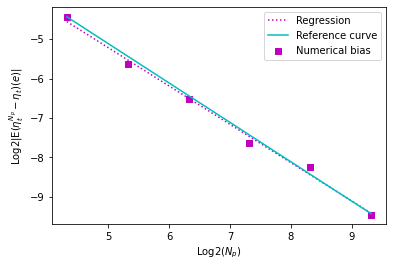

In [24]:
plt.scatter(np.log2(N0*2**abscisas),ordenadas[:,0],label="Numerical bias",marker="s",color="m")

#plt.plot(abscisas,ordenadas[0]-4*np.log2(1/2.)+np.log2(1/2.)*abscisas,label=r"Reference curve $a+l*Log(1/2)$")
[b_meant30dim2,m_meant30dim2]=coef(np.log2(N0*2**abscisas),ordenadas[:,0])
plt.plot(np.log2(N0*2**abscisas),b_meant30dim2+m_meant30dim2*np.log2(N0*2**abscisas),color="m",ls="dotted",label="Regression")
plt.plot(np.log2(N0*2**abscisas),-1*np.log2(N0*2**abscisas)+ordenadas[0,0]+np.log2(N0*2**abscisas)[0],color="c",label="Reference curve")
plt.legend()
plt.xlabel(r"$\operatorname{Log2}(N_p)$")
plt.ylabel(r"$\operatorname{Log2}\left|\operatorname{E}(\eta^{N_p}_t-\eta_t)(e)\right|$")
plt.savefig("BiasNT30dim2.pdf")

In [250]:
np.sqrt(np.sum(b[:,0]**2))

0.8567597726058152

## F2 N=10

In [23]:
def Dfit_k2(seed_val,pmax,T,N0,l,collection_input,z,lz,REP):
    np.random.seed(seed_val)
    [dim,dim_o]=collection_input[0:2]
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    abscisas=np.array(range(0,pmax))+1
    dim=collection_input[0]
    ordenadas=np.zeros((pmax,dim))
    rep_array=np.zeros((REP,dim))
    lmaxE=l
    for i in range(pmax):
        p=i+1
        dt=2**(-lmaxE)
        with progressbar.ProgressBar(max_value=REP) as bar:
            print("Current level is",p,". ",pmax-p,"remaining.")
            for rep in range(REP):
                dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(lmaxE),N0*2**(p)))
                dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(lmaxE),N0*2**(p)))
                w1=np.cumsum(dw1,axis=0) 
                w2=np.cumsum(dw2,axis=0) 
                w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
                w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
                Enk1=DEnKBF(T,l,lz,lmaxE,z,N0*2**(p),collection_input,w1,w2)[0][-1][:,0]
                Enk2=DEnKBF(T,l,lz,lmaxE,z,N0*2**(p-1),collection_input,w1[:,:N0*2**(p-1),:],w2[:,:N0*2**(p-1),:])[0][-1][:,0]
                rep_array[rep]=(Enk1-Enk2)
                bar.update(rep)
        ordenadas[i]=np.mean(rep_array,axis=0)
    bs=np.zeros((dim,2))
    for i in range(dim):
        bs[i]=coef(abscisas,np.log2(np.abs(ordenadas)).T[i])
    ordenadas=np.log2(np.abs(ordenadas))
    return [2**bs,abscisas,ordenadas]

In [24]:
dim=2
T=29
amm=10.
bmm=20.
cmm=10.
lz=11
seed_val_col=5
seed_val_obs=5
np.random.seed(seed_val_col)
collection_input=gen_model(dim)
np.random.seed(seed_val_obs)
[z,v]=gen_data(T,lz,collection_input)

pmax=6
N0=10
l=4
REP=50

In [25]:
seed_val=3
[b,abscisas,ordenadas]=Dfit_k2(seed_val,pmax,T,N0,l,collection_input,z,lz,REP)

Current level is 1 .  5 remaining.


NameError: name 'DEnKBF' is not defined

In [65]:
[b,abscisas,ordenadas]

[array([[0.0651524 , 0.52994765],
        [0.12810911, 0.61867167]]),
 array([1, 2, 3, 4, 5, 6]),
 array([[ -4.30992943,  -2.89298519],
        [ -4.49975971,  -4.82530644],
        [ -7.20475174,  -4.98023501],
        [-10.57735209,  -7.49621478],
        [ -8.84566245,  -5.01543286],
        [ -7.44041545,  -7.1249923 ]])]

Text(0, 0.5, '$\\operatorname{Log2}\\left(\\operatorname{E}\\left(\\eta^{l}_t-\\eta_t\\right)\\right)$')

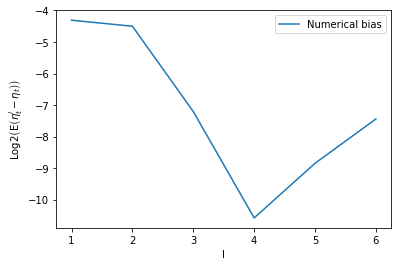

In [66]:
plt.plot(abscisas,ordenadas[:,0],label="Numerical bias")
#plt.plot(abscisas,np.log2(b[0])+np.log2(b[1])*abscisas,label="Linear regression")
#plt.plot(abscisas,ordenadas[0]-4*np.log2(1/2.)+np.log2(1/2.)*abscisas,label=r"Reference curve $a+l*Log(1/2)$")
plt.legend()
plt.xlabel("l")
plt.ylabel(r"$\operatorname{Log2}\left(\operatorname{E}\left(\eta^{l}_t-\eta_t\right)\right)$")

In [67]:
np.sqrt(np.sum(b[:,0]**2))

0.1437246673026819